In [1]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00


In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-2-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 65 Jul  2 15:49 kaggle.json
/content


In [4]:
!kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                      25KB  2023-04-13 09:55:16          39483       1130  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                            6KB  2023-05-28 18:26:48           6698        171  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                22KB  2023-05-12 13:06:39           8337        173  1.0              
mohithsairamreddy/salary-data                

In [5]:
### For Flickr 8k
!kaggle datasets download -w joonrisse/hackathonriseoftransformers
! unzip hackathonriseoftransformers.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078711.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078712.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078713.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078714.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078715.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078716.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078717.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078718.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078719.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078720.jpg  
  inflating: resized_train/resized_train/ImageCLEFmedCaption_2022_train_078721.jpg  
  inflating: r

In [6]:
df = pd.read_csv("/content/caption_prediction_train.csv", delimiter="\t")
df.head()

,ID,caption
0,ImageCLEFmedCaption_2022_train_000001,pericardial tamponade with clear distinction o...
1,ImageCLEFmedCaption_2022_train_000002,angiography of the aortic arch show delay visu...
2,ImageCLEFmedCaption_2022_train_000003,balloonocclude retrograde transvenous oblitera...
3,ImageCLEFmedCaption_2022_train_000004,film after glue embolization show no filling i...
4,ImageCLEFmedCaption_2022_train_000005,peripheral in posteroanterior projection angio...


In [7]:
class CFG:
    debug = False
    image_path = "/content/resized_train/resized_train"
    captions_path = "/content"
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 64

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

In [8]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [9]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [10]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [11]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [12]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [13]:
class ClipLoss(nn.Module):
    def __init__(
            self,
    ):
        super().__init__()

    def get_ground_truth(self, device, num_logits) -> torch.Tensor:
        labels = torch.arange(num_logits, device=device, dtype=torch.long)
        return labels

    def get_logits(self, image_features, text_features, logit_scale):
        logits_per_image = logit_scale * image_features @ text_features.T
        logits_per_text = logit_scale * text_features @ image_features.T
        return logits_per_image, logits_per_text

    def forward(self, image_features, text_features, logit_scale, output_dict=False):
        device = image_features.device
        logits_per_image, logits_per_text = self.get_logits(image_features, text_features, logit_scale)
        labels = self.get_ground_truth(device, logits_per_image.shape[0])
        total_loss = (
            F.cross_entropy(logits_per_image, labels) +
            F.cross_entropy(logits_per_text, labels)
        ) / 2
        return total_loss

In [14]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.loss_fn = ClipLoss()
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        loss = self.loss_fn(image_embeddings, text_embeddings, 0.7)
        return loss


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/caption_prediction_train.csv", delimiter="\t")
    train_dataframe, valid_dataframe = train_test_split(dataframe, test_size=0.10, shuffle=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["ID"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [17]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [18]:
main()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


  0%|          | 0/2343 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/2343 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/2343 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/2343 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

Saved Best Model!


In [19]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [20]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/261 [00:00<?, ?it/s]

In [24]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

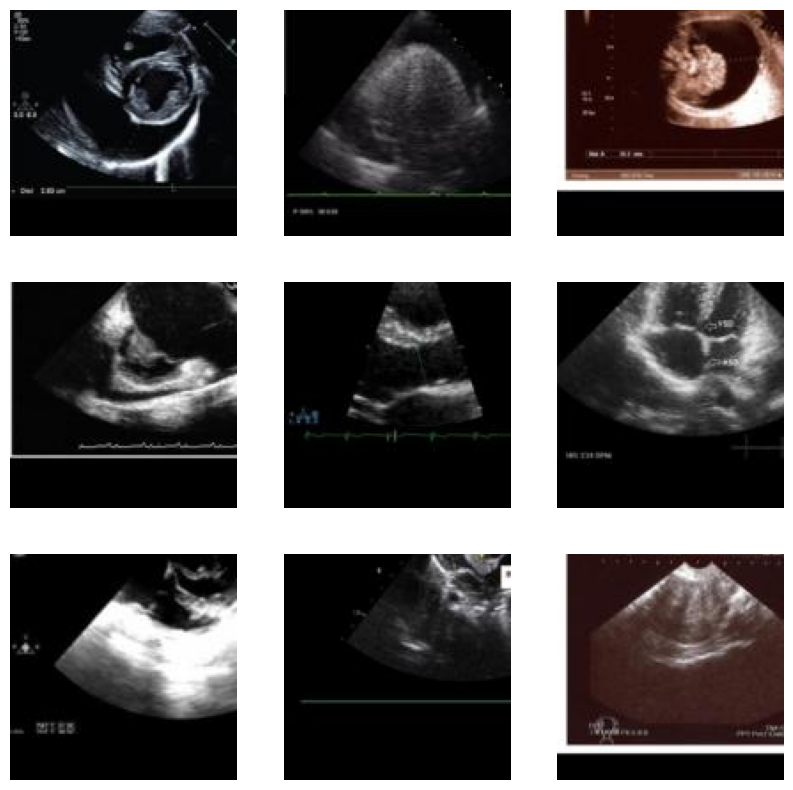

In [26]:
find_matches(model,
             image_embeddings,
             query="pericardial tamponade",
             image_filenames=valid_df['ID'].values,
             n=9)

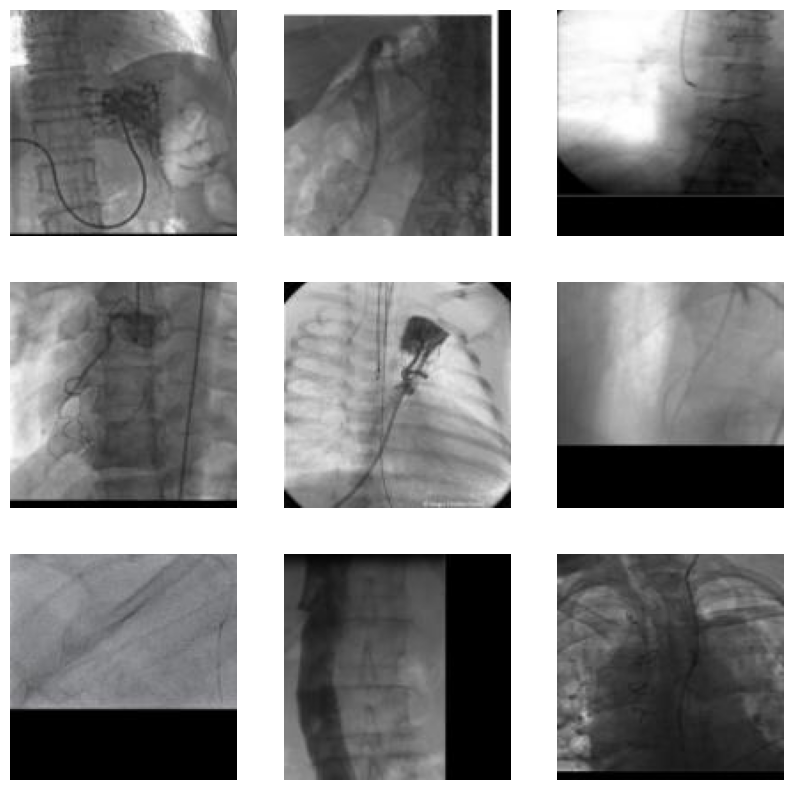

In [29]:
find_matches(model,
             image_embeddings,
             query="balloon catheter",
             image_filenames=valid_df['ID'].values,
             n=9)

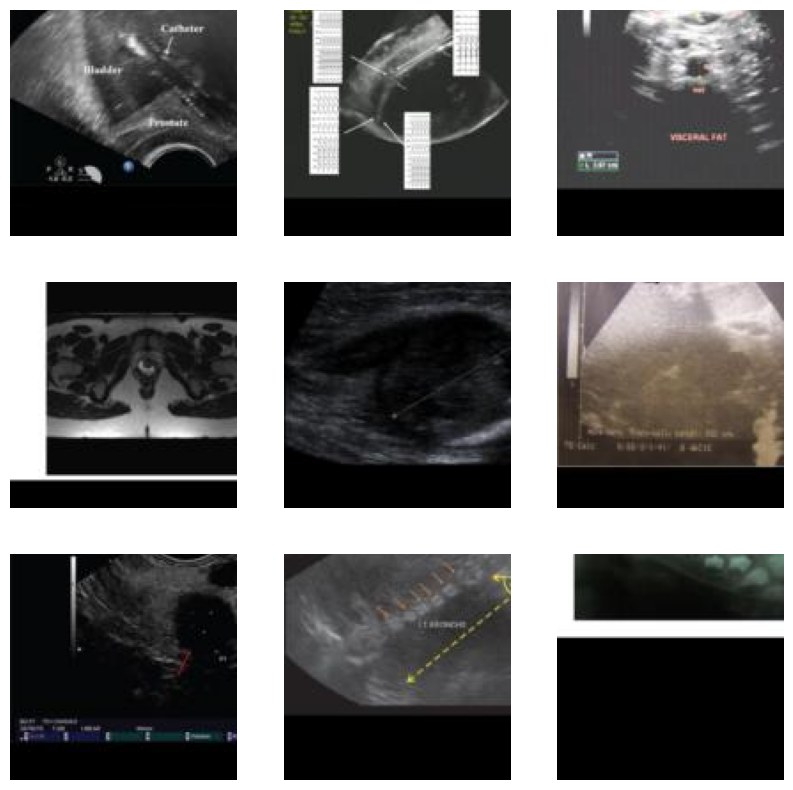

In [32]:
find_matches(model,
             image_embeddings,
             query="visualization of the foramen ovale",
             image_filenames=valid_df['ID'].values,
             n=9)

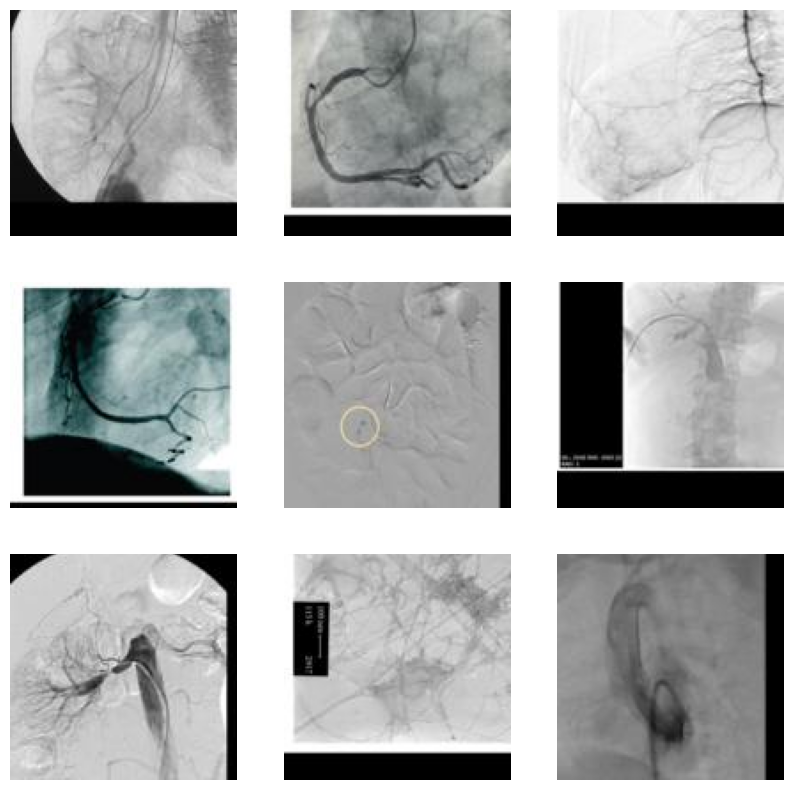

In [33]:
find_matches(model,
             image_embeddings,
             query="angiography",
             image_filenames=valid_df['ID'].values,
             n=9)